In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/ColabNotebooks'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('dataset.csv')

df_target = df.copy().sample(n=10000)
df_data =df_target
df_target=df_target.drop(columns='text')
label_encoder = LabelEncoder()
df_target = label_encoder.fit_transform(df_target)

#df_data = df.copy()
df_data=df_data.drop(columns='humor')
df_data= np.array(df_data['text'])

df_data[:10]


c:\Users\Henry\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(["Amanda lost 110 pounds: 'was it easy? no. was it worth it? yes!'",
       "Why zoe saldana is cool buying her sons' clothes in the girls' section",
       'These 9 famous landmarks look absolutely stunning... until you zoom out',
       'Recipe of the day: chicken sausage pot pie',
       'Heavy fighting between isis and iraqi fighters near falluja',
       "What critics thought of 'jaws' when it was released 40 years ago",
       "Woman's logic: bikini  no problem. bra and underwear:  omg don't look!!!",
       'Celebrate five years of experimental queer film with a lost riot grrrl gem',
       'New season brings new challenges for this up-and-coming composer',
       'Cooking off the cuff: maybe the best way to cook peas'],
      dtype=object)

In [4]:
import itertools
import matplotlib.pyplot as plt


#Confusion matrix to evaluate models
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.preprocessing import DenseTransformer
import numpy as np

# Create internal pipeline
classifier = GaussianNB()
tfidfVectorizer = TfidfVectorizer()

#matrix = tfidfVectorizer.fit_transform(df_data['text'])

#df_data_tfidfVectorized = pd.DataFrame(matrix.toarray(), columns=tfidfVectorizer.get_feature_names())


pipeline = Pipeline(steps=[("transformer", tfidfVectorizer),('to_dense', DenseTransformer()), ("classification", classifier)])



# Specify the tunable hyper parameters
parameters = {
   'transformer__min_df': list(np.arange(0.0033, 0.0035, 0.0001)),
   #'transformer__max_df' : list(np.arange(0.85, 0.99, 0.02)),
   'transformer__max_features' : list(range(140, 160, 10)),
   'transformer__stop_words' : ['english','none'] , 
}

# Define KFold parameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
estimator = GridSearchCV(pipeline, parameters, scoring="accuracy", cv=cv, n_jobs=5)
estimator.fit(df_data, df_target)

print(estimator.best_params_)    

{'transformer__max_features': 140, 'transformer__min_df': 0.0033, 'transformer__stop_words': 'english'}


c:\Users\Henry\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Henry\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Henry\anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Henry\anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Henry\anacond

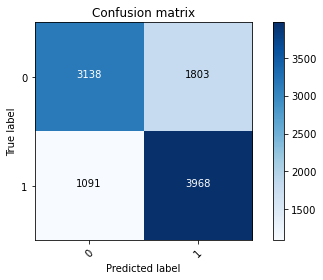

              precision    recall  f1-score   support

           0       0.74      0.64      0.68      4941
           1       0.69      0.78      0.73      5059

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



In [24]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

#estimator.set_params(**estimator.best_params_)
prediction = cross_val_predict(estimator, df_data, df_target, cv=cv, n_jobs=-1)
cm = confusion_matrix(df_target, prediction)
plot_confusion_matrix(cm, classes=unique_labels(df_target))
print(classification_report(df_target, prediction))
plt.show()    